In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import os
import datetime as dt
import gsw
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import cmocean
import json
import f90nml
from collections import OrderedDict

fs=16
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

import warnings
#warnings.filterwarnings('ignore')
from IPython.display import Markdown, display

%matplotlib inline


Import IOS Zooplankton data and create dataframe

In [2]:
ls '/ocean/ksuchy/MOAD/observe/Data and Code files for KS 2020dec11/2020_05_21 1995-2011 SoG VNH.csv'

/ocean/ksuchy/MOAD/observe/Data and Code files for KS 2020dec11/2020_05_21 1995-2011 SoG VNH.csv


In [3]:
df=pd.read_csv('/ocean/ksuchy/MOAD/observe/Data and Code files for KS 2020dec11/2020_05_21 2012-2015 SoG VNH.csv',
               encoding = "ISO-8859-1")

In [5]:
df.keys()

Index(['Key', 'region_name', 'Station', 'PROJECT', 'lon', 'lat', 'Date',
       'STN_TIME', 'Twilight', 'Net_Type', 'Mesh_Size(um)', 'Net_Mouth_Dia(m)',
       'DEPTH_STRT1', 'DEPTH_END1', 'Bottom Depth(m)', 'Volume Filtered(m3)',
       'CTD', 'NOTES', 'PI', 'Phylum:', 'Class:', 'Order:', 'Family:', 'Name',
       'Abundance(#/m3)', 'Biomass(mg/m3)', 'NumberOfSpecies',
       'Station Diversity', 'Station Equitability'],
      dtype='object')

In [6]:
df['Abundance(#/m3)'][2200:2300]

2200     5.51249
2201     2.75624
2202    33.07494
2203    49.61240
2204     5.51249
          ...   
2295    17.61982
2296    22.42523
2297    36.84145
2298     1.60180
2299     0.80090
Name: Abundance(#/m3), Length: 100, dtype: float64

Convert date to proper format

In [7]:
df['Date'][0],df['STN_TIME'][0]

('6/14/2012', '7:32')

In [8]:
df['Date'][1000:1020]

1000    6/15/2012
1001    6/15/2012
1002    6/15/2012
1003    6/15/2012
1004    6/15/2012
1005    6/15/2012
1006    6/15/2012
1007    6/15/2012
1008    6/15/2012
1009    6/15/2012
1010    6/15/2012
1011    6/15/2012
1012    6/15/2012
1013    6/15/2012
1014    6/15/2012
1015    6/15/2012
1016    6/15/2012
1017    6/15/2012
1018    6/15/2012
1019    6/15/2012
Name: Date, dtype: object

In [9]:
df['Date'][0].split('/')

['6', '14', '2012']

In [10]:
dateslist=list()

In [11]:
for el in df['Date']:
    dateslist.append(el.split('/'))

In [12]:
timeslist=list()
for el in df['STN_TIME']:
    timeslist.append(el.split(':'))

In [13]:
dts=list()
for ii,jj in zip(dateslist,timeslist):
    dts.append(dt.datetime(int(ii[2]),int(ii[0]),int(ii[1]),int(jj[0]),int(jj[1])))

In [14]:
df.loc[df.Twilight=='Daylight']['STN_TIME'].unique()

array(['7:32', '7:52', '3:30', '7:42', '7:49', '15:09', '16:30', '22:09',
       '22:27', '19:36', '19:53', '9:21', '9:35', '13:29', '13:45',
       '19:25', '19:43', '5:26', '5:43', '5:45', '5:47', '5:56', '5:59',
       '8:38', '8:39', '8:40', '8:41', '8:57', '11:10', '11:44', '11:45',
       '11:47', '11:48', '11:49', '12:40', '12:42', '15:14', '15:15',
       '15:16', '15:17', '15:18', '17:54', '17:55', '17:57', '17:58',
       '17:59', '5:39', '6:05', '14:47', '15:02', '19:13', '19:30',
       '14:32', '14:49', '20:04', '20:24', '20:27', '20:47', '9:37',
       '9:48', '13:57', '14:17', '19:41', '19:59', '7:18', '7:53', '9:25',
       '12:57', '13:09', '7:30', '7:45', '13:33', '13:36', '13:38',
       '10:00', '10:30', '11:00', '11:30', '12:30', '13:00', '13:30',
       '16:00', '17:00', '9:29', '10:26', '11:19', '13:39', '9:16',
       '10:04', '10:42', '11:03', '9:00', '9:41', '10:17', '10:40',
       '12:00', '9:33', '10:13', '11:11', '12:02', '12:32', '13:22',
       '9:57', '

In [15]:
df['dtUTC']=et.pac_to_utc(dts) #convert from Pac time to UTC

In [16]:
df['Order:'].unique()

array(['Diplostraca', 'Thecostraca', 'Amphipoda', 'Decapoda',
       'Euphausiacea', 'Calanoida', 'Cyclopoida', 'Poecilostomatoida',
       'Halocyprida', 'Aphragmophora', 'Copelata', 'Leptothecate',
       'Siphonophorae', 'Trachylina', 'Cydippida', nan, 'Pholadomyoida',
       'Neotaenioglossa', 'Thecosomata', 'Aciculata', 'Canalipalpata',
       'Osmeriformes', 'Perciformes', 'Beroida', 'Teuthida',
       'Gymnosomata', 'Isopoda', 'Siphonostomatoida', 'Anthoathecatae',
       'Scorpaeniformes', 'Phragmophora', 'Clupeiformes', 'Ophiurida',
       'Gadiformes', 'Semaeostomeae', 'Cumacea', 'Echinoida',
       'Harpacticoida', 'Pleuronectiformes', 'Tricladida', 'Myodocopida',
       'Phaeogromia', 'Noctilucales', 'Octopoda', 'Actiniaria',
       'Foraminiferida', 'Monstrilloida', 'Oligotrichida', 'Mysida',
       'Acariformes', 'Lophogastrida', 'Ophidiiformes',
       'Thalassocalycida', 'Doliolida', 'Lepadomorpha', 'Cephalaspidea',
       'Sygnathiformes'], dtype=object)

## Start by creating a group of zooplankton taxa of interest

In [18]:
colList=('Anomura *sp. megalops s1',
 'Anomura *sp. zoea s1' ,'Anomura *sp. zoea s2', 'Axiidae *sp.  s1', 'Axiidae *sp. mysis s2',
 'Axiidae *sp. zoea s1' ,'Axiidae *sp. zoea s2','Brachyura *sp. zoea s1',
'Calanoida *sp.  1', 'Calanoida *sp.  2' ,'Calanoida *sp.  3',
 'Calanoida *sp.  4' ,'Calanoida *sp.  6M', 'Calanus *sp.  1',
 'Calanus *sp.  2', 'Calanus *sp.  3' ,'Calanus *sp.  4',
 'Calanus *sp. nauplii s1', 'Calanus marshallae  2' ,'Calanus marshallae  3',
 'Calanus marshallae  4' ,'Calanus marshallae  5' ,'Calanus marshallae  6F',
 'Calanus marshallae  6M' ,'Calanus pacificus  2' ,'Calanus pacificus  3',
 'Calanus pacificus  4' ,'Calanus pacificus  5', 'Calanus pacificus  6F',
 'Calanus pacificus  6M','Calliopius *sp.  s1' ,'Calliopius *sp.  s2', 'Calliopius *sp.  s3',
 'Calliopius pacificus  s1' ,'Calliopius pacificus  s2',
 'Calliopius pacificus  s3', 'Cancer *sp. megalops s1',
 'Cancer *sp. zoea s1' ,'Cancer *sp. zoea s2', 'Cancer magister megalops s2',
 'Cancer magister zoea s1' ,'Cancer magister zoea s2',
 'Cancer oregonensis megalops s1', 'Cancer oregonensis megalops s2',
 'Cancer productus megalops s1' ,'Cancer productus megalops s2',
 'Cancer productus zoea s1' ,'Cancer productus zoea s2','Caridea *sp.  s3' ,'Caridea *sp. mysis s1',
 'Caridea *sp. mysis s2', 'Caridea *sp. mysis s3' ,'Caridea *sp. zoea s1',
 'Caridea *sp. zoea s2', 'Chaetognatha *sp.  s3' ,'Chaetognatha *sp. juvenile s1',
 'Chaetognatha *sp. juvenile s2','Chionoecetes *sp. megalops s1',
 'Chionoecetes *sp. megalops s2', 'Chionoecetes *sp. zoea s1','Corycaeus anglicus  3',
 'Corycaeus anglicus  4' ,'Corycaeus anglicus  5' ,'Corycaeus anglicus  6F',
 'Corycaeus anglicus  6M' ,'Crangonidae *sp. mysis s1',
 'Crangonidae *sp. mysis s2' ,'Crangonidae *sp. mysis s3',
 'Crangonidae *sp. zoea s1', 'Crangonidae *sp. zoea s2','Cyphocaris *sp.  s1',
 'Cyphocaris challengeri  s1' ,'Cyphocaris challengeri  s2',
 'Cyphocaris challengeri  s3', 'Decapoda *sp. zoea s1','Eucalanus *sp.  1',
 'Eucalanus *sp.  2' ,'Eucalanus *sp.  3' ,'Eucalanus *sp. nauplii s1',
 'Eucalanus bungii  3', 'Eucalanus bungii  4', 'Eucalanus bungii  4F',
 'Eucalanus bungii  4M', 'Eucalanus bungii  5F', 'Eucalanus bungii  5M',
 'Eucalanus bungii  6F', 'Eucalanus bungii  6M',
 'Eucalanus californicus  5F', 'Eucalanus californicus  6F','Euphausia pacifica  F',
 'Euphausia pacifica  M' ,'Euphausia pacifica  s2', 'Euphausia pacifica  s3',
 'Euphausia pacifica eggs s1' ,'Euphausia pacifica nauplii s1',
 'Euphausia pacifica zoea s1', 'Euphausiacea *sp.  s2',
 'Euphausiidae *sp. eggs s1', 'Euphausiidae *sp. nauplii s1',
 'Euphausiidae *sp. protozoea (or calyptopis) s1',
 'Euphausiidae *sp. zoea (or furcilia) s1','Galatheidae *sp. zoea s1', 'Galatheidae *sp. zoea s2',
 'Gammaridea *sp.  s1', 'Gammaridea *sp.  s2','Grapsidae *sp. megalops s1', 'Grapsidae *sp. zoea s1','Hemigrapsus *sp. megalops s1'
 ,'Hemigrapsus *sp. zoea s1','Hyperia medusarum  F', 'Hyperia medusarum  M',
 'Hyperia medusarum  s1', 'Hyperia medusarum  s2' ,'Limacina helicina  s0',
 'Limacina helicina  s1' ,'Limacina helicina  s2','Lithodidae *sp. megalops s1',
 'Lithodidae *sp. zoea s1', 'Lithodidae *sp. zoea s2','Lophopanopeus *sp. megalops s1','Majidae *sp. megalops s1',
 'Majidae *sp. megalops s2', 'Majidae *sp. zoea s1','Metridia *sp.  1',
 'Metridia *sp.  2', 'Metridia *sp.  3' ,'Metridia *sp.  4',
 'Metridia *sp.  5', 'Metridia *sp.  6F', 'Metridia *sp.  6M',
 'Metridia pacifica  3' ,'Metridia pacifica  4' ,'Metridia pacifica  5F',
 'Metridia pacifica  5M' 'Metridia pacifica  6F' 'Metridia pacifica  6M'
 'Metridia pseudopacifica  5', 'Metridia pseudopacifica  6F',
 'Metridia pseudopacifica  6M' ,'Munida *sp. zoea s1' ,'Munida *sp. zoea s2',
 'Munida quadrispina megalops s2', 'Munida quadrispina megalops s3','Neocalanus *sp.  4',
 'Neocalanus *sp. eggs s1', 'Neocalanus *sp. nauplii s1',
 'Neocalanus cristatus  2', 'Neocalanus cristatus  3',
 'Neocalanus cristatus  4', 'Neocalanus cristatus  5',
 'Neocalanus cristatus  6F' ,'Neocalanus cristatus  6M',
 'Neocalanus plumchrus  1', 'Neocalanus plumchrus  2',
 'Neocalanus plumchrus  3', 'Neocalanus plumchrus  4',
 'Neocalanus plumchrus  5', 'Neocalanus plumchrus  6F',
 'Neocalanus plumchrus  6M' ,'Neotrypaea *sp. mysis s1',
 'Neotrypaea *sp. mysis s2', 'Neotrypaea *sp. zoea s1',
 'Neotrypaea *sp. zoea s2', 'Oikopleura *sp.  s1', 'Oikopleura *sp.  s2',
 'Oikopleura dioica  s1' ,'Oikopleura dioica  s2',
 'Oikopleura labradoriensis  s1', 'Oikopleura labradoriensis  s2',
 'Oikopleura labradoriensis  s3', 'Oregonia *sp. megalops s1','Paguridae *sp. megalops s1' ,'Paguridae *sp. megalops s2',
 'Paguridae *sp. zoea s1', 'Paguridae *sp. zoea s2',
 'Pandalidae *sp. mysis s2', 'Pandalidae *sp. mysis s3',
 'Pandalidae *sp. zoea s1', 'Pandalidae *sp. zoea s2',
 'Pandalopsis dispar  s2' ,'Pandalopsis dispar  s3' ,'Pandalus danae  s2',
 'Pandalus danae  s3', 'Pandalus eous  s3', 'Pandalus jordani  s2',
 'Pandalus jordani  s3', 'Pandalus stenolepis  s1',
 'Pandalus stenolepis  s2', 'Pandalus stenolepis  s3',
 'Pandalus tridens  s2' ,'Pandalus tridens  s3','Parasagitta elegans  s2', 'Parasagitta elegans  s3',
 'Parasagitta elegans juvenile s1', 'Parasagitta euneritica  s2',
 'Parasagitta euneritica  s3','Pinnixa *sp. megalops s1', 'Pinnotheres *sp. megalops s1',
 'Pinnotheridae *sp. megalops s1', 'Pinnotheridae *sp. megalops s2',
 'Pinnotheridae *sp. zoea s1' ,'Pinnotheridae *sp. zoea s2',
 'Pisidae zoea zoea s1', 'Porcellanidae *sp. megalops s1', 'Porcellanidae *sp. zoea s1',
 'Porcellanidae *sp. zoea s2', 'Primno *sp.  s1', 'Primno abyssalis  F',
 'Primno abyssalis  M', 'Primno abyssalis  s1', 'Primno abyssalis  s2',
 'Primno brevidens  s1' ,'Pugettia *sp. megalops s1', 'Themisto *sp.  s1',
 'Themisto pacifica  F', 'Themisto pacifica  M', 'Themisto pacifica  s2',
 'Themisto pacifica juvenile s1', 'Thysanoessa *sp.  s1',
 'Thysanoessa *sp.  s2', 'Thysanoessa *sp. nauplii s1',
 'Thysanoessa *sp. zoea s1', 'Thysanoessa longipes  F',
 'Thysanoessa longipes  M', 'Thysanoessa longipes  s2',
 'Thysanoessa longipes  s3' ,'Thysanoessa longipes zoea s1',
 'Thysanoessa raschii  F', 'Thysanoessa raschii  M',
 'Thysanoessa raschii  s2' ,'Thysanoessa raschii zoea s1',
 'Thysanoessa spinifera  F', 'Thysanoessa spinifera  M',
 'Thysanoessa spinifera  s2', 'Thysanoessa spinifera  s3',
 'Thysanoessa spinifera eggs s1', 'Thysanoessa spinifera nauplii s1',
 'Thysanoessa spinifera zoea s1','Xanthidae *sp. megalops s1',
 'Xanthidae *sp. zoea s1')


In [19]:
df.keys()

Index(['Key', 'region_name', 'Station', 'PROJECT', 'lon', 'lat', 'Date',
       'STN_TIME', 'Twilight', 'Net_Type', 'Mesh_Size(um)', 'Net_Mouth_Dia(m)',
       'DEPTH_STRT1', 'DEPTH_END1', 'Bottom Depth(m)', 'Volume Filtered(m3)',
       'CTD', 'NOTES', 'PI', 'Phylum:', 'Class:', 'Order:', 'Family:', 'Name',
       'Abundance(#/m3)', 'Biomass(mg/m3)', 'NumberOfSpecies',
       'Station Diversity', 'Station Equitability', 'dtUTC'],
      dtype='object')

In [20]:
dtsutc=et.pac_to_utc(dts)

In [21]:
df.loc[0]

Key                                                      IOS2012005000901
region_name                                    Northern Strait of Georgia
Station                                                                22
PROJECT                                                         Str. Geo.
lon                                                              -124.272
lat                                                                 49.67
Date                                                            6/14/2012
STN_TIME                                                             7:32
Twilight                                                         Daylight
Net_Type                                                         SCOR VNH
Mesh_Size(um)                                                         236
Net_Mouth_Dia(m)                                                     0.56
DEPTH_STRT1                                                            50
DEPTH_END1                            

In [22]:
towIDlist=['Key', 'region_name', 'Station',  'lon', 'lat','Date', 'dtUTC', 'Twilight', 'Net_Type', 'Mesh_Size(um)', 'DEPTH_STRT1', 'DEPTH_END1', 'Bottom Depth(m)']

In [23]:
towIDlist2=['Key', 'region_name', 'Station',  'lon', 'lat','Date', 'dtUTC', 'Twilight', 'Net_Type', 'Mesh_Size(um)', 'DEPTH_STRT1', 'DEPTH_END1', 'Bottom Depth(m)','CTD']

In [24]:
len(df.groupby(towIDlist)),len(df.groupby(towIDlist2)),len(df.groupby(['Key']))

(654, 12694, 654)

In [25]:
# Key is a unique identifier for each tow
# do not group by CTD due to NaN values

In [30]:
df['Month']=[ii.month for ii in df['dtUTC']]

In [34]:
len(df.loc[df.Month==2]['Key'].unique())

13

In [39]:
test=df.loc[(df.Month==2)&(df['Order:']=='Calanoida')].groupby(['Key']).sum()

In [49]:
test

,lon,lat,Mesh_Size(um),Net_Mouth_Dia(m),DEPTH_STRT1,DEPTH_END1,Bottom Depth(m),Volume Filtered(m3),CTD,Abundance(#/m3),Biomass(mg/m3),NumberOfSpecies,Station Diversity,Station Equitability,Month
Key,,,,,,,,,,,,,,,
IOS2015001000201A,-4067.085,1604.262,7788,18.48,6732,0,7491,1574.43,99.0,228.25407,5.45896,1452,65.34,17.16,66
IOS2015001000701A,-6820.110,2656.500,12980,30.80,9735,0,10285,1885.95,275.0,80.92749,3.33723,2915,176.00,44.55,110
IOS2015008000501,-5808.025,2292.190,9400,23.50,2773,0,2820,462.95,188.0,422.43662,3.71556,2538,94.00,23.97,94
IOS2015008000801,-3955.936,1560.000,6400,16.00,960,0,960,158.08,224.0,398.78547,1.77838,1152,72.00,20.16,64
IOS2015008001201,-5191.452,2047.416,8400,21.00,2226,0,2394,312.06,462.0,397.71195,4.57015,2016,77.28,20.16,84
IOS2015008001601,-5437.256,2144.472,8800,22.00,3080,0,3212,473.44,660.0,461.98892,5.28456,2332,87.12,22.00,88
IOS2015099000101,-6328.692,2528.733,12036,28.56,10200,0,13464,2135.37,102.0,262.04919,15.79196,2754,131.58,32.64,102
IOS2015099000201,-6558.644,2610.356,12508,29.68,13038,0,21200,3302.43,159.0,170.91952,14.82036,3286,126.67,30.74,106
IOS2015099000301,-7981.952,3181.120,15104,35.84,16000,0,19136,3584.64,0.0,205.39196,8.40212,4608,159.36,37.12,128


In [65]:
temp=df.loc[(df.Month==2)&(df['Order:']=='Calanoida'),['Name','Biomass(mg/m3)']].groupby('Name',as_index=False).sum().sort_values(['Biomass(mg/m3)'],ascending=False)

In [70]:
if 'Neocalanus plumchrus  1' in colList:
    print('yes')

yes


In [72]:
np.sum(np.isnan(df['Biomass(mg/m3)']))

0

In [74]:
temp=df.loc[(df.Month==2)&(df['Order:']=='Calanoida'),['Name','Biomass(mg/m3)']].groupby('Name',as_index=False).sum()\
        .sort_values(['Biomass(mg/m3)'],ascending=False)
print('Total:',np.sum(temp['Biomass(mg/m3)']))
bsum=0
for i in range(0,len(temp)):
    print(temp['Name'][i],np.sum(temp['Biomass(mg/m3)'][:(i+1)])/np.sum(temp['Biomass(mg/m3)']))
    if temp['Name'][i] in colList:
        bsum=bsum+temp['Biomass(mg/m3)'][(i+1)]
print('included:',bsum)
print('fraction included:',bsum/np.sum(temp['Biomass(mg/m3)']))

Total: 91.05689
Acartia *sp.  1 0.1524709442635258
Acartia *sp.  3 0.29484666124661185
Acartia *sp.  4 0.3680829643973125
Acartia hudsonica  6F 0.4329025513610228
Acartia hudsonica  6M 0.49399644551884
Acartia longiremis  5 0.5431409967988144
Acartia longiremis  6F 0.5886318981463128
Acartia longiremis  6M 0.6190386032292559
Aetideidae *sp.  1 0.6439498427850984
Aetideidae *sp.  2 0.6671245855201072
Aetideus divergens  4 0.6864790791778634
Aetideus divergens  5 0.7047988351018797
Aetideus divergens  6F 0.7226583293147834
Aetideus divergens  6M 0.7390363321216001
Calanoida *sp.  1 0.7541849935792889
Calanoida *sp.  2 0.7665354044048726
Calanus *sp.  1 0.7788231071805769
Calanus *sp.  2 0.790237839223369
Calanus *sp. nauplii s1 0.8015660319608983
Calanus marshallae  5 0.8112372386098404
Calanus marshallae  6F 0.8207127434288607
Calanus marshallae  6M 0.829321427516358
Calanus pacificus  4 0.8376354606444388
Calanus pacificus  5 0.8458247366014807
Calanus pacificus  6F 0.8535784606744201


In [66]:
temp['Name'][0]

'Acartia *sp.  1'

In [45]:
10**(np.sum(np.log10(test['Biomass(mg/m3)']))/13)

5.784098014243127

In [43]:
10**(np.sum(np.log10(test['Abundance(#/m3)']))/13)

273.85192568125007

In [44]:
10**(np.sum(np.log10(test['Abundance(#/m3)']))/13)*(4.13*(1.8**3.92))*0.45/1000

5.097374999675256

In [48]:
10**(np.sum(np.log10(test['Abundance(#/m3)']))/13)*4.13*(0.5**3.28)*0.45/1000

0.05239622263482247

### Create an abundance dataframe

In [26]:
biomassDF=df.groupby(towIDlist,as_index=False).first()\
     .loc[:,towIDlist].copy(deep=True)

In [27]:
biomassDF

,Key,region_name,Station,lon,lat,Date,dtUTC,Twilight,Net_Type,Mesh_Size(um),DEPTH_STRT1,DEPTH_END1,Bottom Depth(m)
0,IOS2012005000901,Northern Strait of Georgia,22,-124.272,49.670,6/14/2012,2012-06-14 14:32:00,Daylight,SCOR VNH,236,50,0,352
1,IOS2012005001001,Northern Strait of Georgia,22,-124.272,49.670,6/14/2012,2012-06-14 14:52:00,Daylight,SCOR VNH,236,345,0,352
2,IOS2012005002101,Northern Strait of Georgia,11,-124.722,49.710,6/14/2012,2012-06-14 07:00:00,Night,SCOR VNH,236,50,0,307
3,IOS2012005002201,Northern Strait of Georgia,11,-124.722,49.710,6/14/2012,2012-06-14 07:05:00,Night,SCOR VNH,236,300,0,307
4,IOS2012005002901,Northern Strait of Georgia,CPF2,-124.499,49.466,6/15/2012,2012-06-15 10:00:00,Night,SCOR VNH,236,50,0,325
...,...,...,...,...,...,...,...,...,...,...,...,...,...
649,SOO2015095000101,Tidal Mixed,CLO-42,-123.345,48.394,4/27/2015,2015-04-27 17:37:00,Daylight,SCOR VNH,236,58,0,72
650,SOO2015095000401,Tidal Mixed,CB01,-123.318,48.344,4/30/2015,2015-04-30 19:00:00,Daylight,SCOR VNH,236,54,0,64
651,SOO2015095000501,Tidal Mixed,CLO-41,-123.345,48.395,7/9/2015,2015-07-09 19:25:00,Daylight,SCOR VNH,236,42,0,64
652,SOO2015095000701,Tidal Mixed,CB01,-123.318,48.344,7/27/2015,2015-07-27 19:06:00,Daylight,SCOR VNH,236,28,0,60


In [28]:
#### Get abundance column to input into biomassDF as these abundance values will be multiplied by carbon conversion equations

In [29]:
#for icol in colList:
#    biomassDF[icol]=[getabundance(icol,ikey,df,'Name') for ikey in biomassDF['Key']]

In [30]:
#for icol in colList:
#    biomassDF[icol]=[getabundance(icol,ikey,df) for ikey in biomassDF['Key']]

In [32]:
def getabundance(colname,key,origdf):        
    abundanceArray=origdf.loc[(origdf.Key==key)&(origdf['Name']==colname),
                    ['Abundance(#/m3)']]
    if len(abundanceArray)>1:
        print(len(abundanceArray),colname,key)
    abundance=np.nansum(abundanceArray)
    
    return abundance

In [33]:
for icol in colList:
    biomassDF[icol]=[getabundance(icol,ikey,df) for ikey in biomassDF['Key']]

In [38]:
biomassDF.loc[biomassDF.Key=='IOS2012005000901',['Calanus *sp.  1']]

,Calanus *sp. 1
0,3.05635


In [37]:
biomassDF

,Key,region_name,Station,lon,lat,Date,dtUTC,Twilight,Net_Type,Mesh_Size(um),...,Thysanoessa raschii zoea s1,Thysanoessa spinifera F,Thysanoessa spinifera M,Thysanoessa spinifera s2,Thysanoessa spinifera s3,Thysanoessa spinifera eggs s1,Thysanoessa spinifera nauplii s1,Thysanoessa spinifera zoea s1,Xanthidae *sp. megalops s1,Xanthidae *sp. zoea s1
0,IOS2012005000901,Northern Strait of Georgia,22,-124.272,49.670,6/14/2012,2012-06-14 14:32:00,Daylight,SCOR VNH,236,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,IOS2012005001001,Northern Strait of Georgia,22,-124.272,49.670,6/14/2012,2012-06-14 14:52:00,Daylight,SCOR VNH,236,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,IOS2012005002101,Northern Strait of Georgia,11,-124.722,49.710,6/14/2012,2012-06-14 07:00:00,Night,SCOR VNH,236,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,IOS2012005002201,Northern Strait of Georgia,11,-124.722,49.710,6/14/2012,2012-06-14 07:05:00,Night,SCOR VNH,236,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,IOS2012005002901,Northern Strait of Georgia,CPF2,-124.499,49.466,6/15/2012,2012-06-15 10:00:00,Night,SCOR VNH,236,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
649,SOO2015095000101,Tidal Mixed,CLO-42,-123.345,48.394,4/27/2015,2015-04-27 17:37:00,Daylight,SCOR VNH,236,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
650,SOO2015095000401,Tidal Mixed,CB01,-123.318,48.344,4/30/2015,2015-04-30 19:00:00,Daylight,SCOR VNH,236,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
651,SOO2015095000501,Tidal Mixed,CLO-41,-123.345,48.395,7/9/2015,2015-07-09 19:25:00,Daylight,SCOR VNH,236,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
652,SOO2015095000701,Tidal Mixed,CB01,-123.318,48.344,7/27/2015,2015-07-27 19:06:00,Daylight,SCOR VNH,236,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [283]:
biomassDF.keys()[1:100]

Index(['region_name', 'Station', 'Lon', 'Lat', 'Date', 'dtUTC', 'Twilight',
       'Net_Type', 'Mesh_Size(um)', 'Z_lower', 'Z_upper', 'Bottom Depth(m)',
       'Anomura *sp. megalops s1', 'Anomura *sp. zoea s1',
       'Anomura *sp. zoea s2', 'Axiidae *sp.  s1', 'Axiidae *sp. mysis s2',
       'Axiidae *sp. zoea s1', 'Axiidae *sp. zoea s2',
       'Brachyura *sp. zoea s1', 'Calanoida *sp.  1', 'Calanoida *sp.  2',
       'Calanoida *sp.  3', 'Calanoida *sp.  4', 'Calanoida *sp.  6M',
       'Calanus *sp.  1', 'Calanus *sp.  2', 'Calanus *sp.  3',
       'Calanus *sp.  4', 'Calanus *sp. nauplii s1', 'Calanus marshallae  2',
       'Calanus marshallae  3', 'Calanus marshallae  4',
       'Calanus marshallae  5', 'Calanus marshallae  6F',
       'Calanus marshallae  6M', 'Calanus pacificus  2',
       'Calanus pacificus  3', 'Calanus pacificus  4', 'Calanus pacificus  5',
       'Calanus pacificus  6F', 'Calanus pacificus  6M', 'Calliopius *sp.  s1',
       'Calliopius *sp.  s2', 'Calliop

In [177]:
# define log transform function
def log(x):
  return np.log10(x)

### Convert Abundances to new Biomass values using Puget Sound LW Regressions

### Copepod Conversions

#### Neocalanus conversion C (ug):

In [39]:
biomassDF['Neocalanus plumchrus  1']=(biomassDF['Neocalanus plumchrus  1']*(4.13*(0.9**3.28))*0.45)/1000
biomassDF['Neocalanus plumchrus  2']=(biomassDF['Neocalanus plumchrus  2']*(4.13*(1.1**3.28))*0.45)/1000
biomassDF['Neocalanus plumchrus  3']=(biomassDF['Neocalanus plumchrus  3']*(4.13*(1.75**3.28))*0.45)/1000
biomassDF['Neocalanus plumchrus  4']=(biomassDF['Neocalanus plumchrus  4']*(4.13*(2.6**3.28))*0.45)/1000
biomassDF['Neocalanus plumchrus  5']=(biomassDF['Neocalanus plumchrus  5']*(2.00*(3.8**3.92))*0.5)/1000
biomassDF['Neocalanus plumchrus  6F']=(biomassDF['Neocalanus plumchrus  6F']*(2.00*(4.5**3.92))*0.5)/1000
biomassDF['Neocalanus plumchrus  6M']=(biomassDF['Neocalanus plumchrus  6M']*(2.00*(4.5**3.92))*0.5)/1000

#### Calanus Conversions C (ug):

In [40]:
#check these lengths/regression equations
biomassDF['Calanoida *sp.  1']=(biomassDF['Calanoida *sp.  1']*(4.13*(0.5**3.28))*0.45)/1000
biomassDF['Calanoida *sp.  2']=(biomassDF['Calanoida *sp.  2']*(4.13*(0.8**3.28))*0.45)/1000
biomassDF['Calanoida *sp.  3']=(biomassDF['Calanoida *sp.  3']*(4.13*(1.2**3.28))*0.45)/1000
biomassDF['Calanoida *sp.  4']=(biomassDF['Calanoida *sp.  4']*(4.13*(1.4**3.28))*0.45)/1000
biomassDF['Calanoida *sp.  6M']=(biomassDF['Calanoida *sp.  6M']*(2.00*(2.1**3.92))*0.45)/1000

In [41]:
#check these lengths/regression equations
biomassDF['Calanus *sp.  1']=(biomassDF['Calanus *sp.  1']*(4.13*(0.5**3.28))*0.45)/1000
biomassDF['Calanus *sp.  2']=(biomassDF['Calanus *sp.  2']*(4.13*(0.8**3.28))*0.45)/1000
biomassDF['Calanus *sp.  3']=(biomassDF['Calanus *sp.  3']*(4.13*(1.2**3.28))*0.45)/1000
biomassDF['Calanus *sp.  4']=(biomassDF['Calanus *sp.  4']*(4.13*(1.4**3.28))*0.45)/1000
biomassDF['Calanus *sp. nauplii s1']=(biomassDF['Calanus *sp. nauplii s1']*(4.13*(0.4**3.28))*0.45)/1000

In [42]:
biomassDF['Calanus pacificus  2']=(biomassDF['Calanus pacificus  2']*(4.13*(0.8**3.28))*0.45)/1000
biomassDF['Calanus pacificus  3']=(biomassDF['Calanus pacificus  3']*(4.13*(1.1**3.28))*0.45)/1000
biomassDF['Calanus pacificus  4']=(biomassDF['Calanus pacificus  4']*(4.13*(1.4**3.28))*0.45)/1000
biomassDF['Calanus pacificus  5']=(biomassDF['Calanus pacificus  5']*(2.00*(1.8**3.92))*0.45)/1000
biomassDF['Calanus pacificus  6F']=(biomassDF['Calanus pacificus  6F']*(2.00*(2.2**3.92))*0.45)/1000
biomassDF['Calanus pacificus  6M']=(biomassDF['Calanus pacificus  6M']*(2.00*(2.1**3.92))*0.45)/1000


In [43]:
biomassDF['Calanus marshallae  2']=(biomassDF['Calanus marshallae  2']*(4.13*(0.8**3.28))*0.45)/1000
biomassDF['Calanus marshallae  3']=(biomassDF['Calanus marshallae  3']*(4.13*(1.6**3.28))*0.45)/1000
biomassDF['Calanus marshallae  4']=(biomassDF['Calanus marshallae  4']*(4.13*(2.0**3.28))*0.45)/1000
biomassDF['Calanus marshallae  5']=(biomassDF['Calanus marshallae  5']*(2.00*(2.5**3.92))*0.45)/1000
biomassDF['Calanus marshallae  6F']=(biomassDF['Calanus marshallae  6F']*(2.00*(2.8**3.92))*0.45)/1000
biomassDF['Calanus marshallae  6M']=(biomassDF['Calanus marshallae  6M']*(2.00*(2.6**3.92))*0.45)/1000

#### Metridia conversions C (ug):

#need lengths for these groups. Should they be included?
'Metridia *sp.  2', 'Metridia *sp.  3' ,'Metridia *sp.  4',
 'Metridia *sp.  5', 'Metridia *sp.  6F', 'Metridia *sp.  6M',
 'Metridia pseudopacifica  5', 'Metridia pseudopacifica  6F',
 'Metridia pseudopacifica  6M'

In [44]:
biomassDF['Metridia *sp.  2']=(biomassDF['Metridia *sp.  2']*(4.13*(0.4**3.28))*0.45)/1000
biomassDF['Metridia *sp.  3']=(biomassDF['Metridia *sp.  3']*(4.13*(0.7**3.28))*0.45)/1000
biomassDF['Metridia *sp.  4']=(biomassDF['Metridia *sp.  4']*(4.13*(1.1**3.28))*0.45)/1000
biomassDF['Metridia *sp.  5']=(biomassDF['Metridia *sp.  5']*(4.13*(1.3**3.28))*0.45)/1000
biomassDF['Metridia *sp.  6F']=(biomassDF['Metridia *sp.  6F']*(4.13*(2.0**3.28))*0.45)/1000
biomassDF['Metridia *sp.  6M']=(biomassDF['Metridia *sp.  6M']*(4.13*(1.4**3.28))*0.45)/1000
biomassDF['Metridia pacifica  3']=(biomassDF['Metridia pacifica  3']*(4.13*(0.7**3.28))*0.45)/1000
biomassDF['Metridia pacifica  4']=(biomassDF['Metridia pacifica  4']*(4.13*(1.1**3.28))*0.45)/1000
biomassDF['Metridia pacifica  5F']=(biomassDF['Metridia pacifica  5F']*(4.13*(1.5**3.28))*0.45)/1000
#biomassDF['Metridia pacifica  5M']=biomassDF['Metridia pacifica  5M']*(4.13*(1.3**3.28))*0.45
#biomassDF['Metridia pacifica  6F']=biomassDF['Metridia pacifica  6F']*(4.13*(2.0**3.28))*0.45
#biomassDF['Metridia pacifica  6M']=biomassDF['Metridia pacifica  6M']*(4.13*(1.4**3.28))*0.45

In [45]:
biomassDF['Metridia *sp.  2'].unique()[1:20]

array([0.00260935, 0.02090429, 0.0086791 , 0.01314684, 0.00035168,
       0.01081596, 0.00156882, 0.01201997, 0.00216238, 0.02722169,
       0.00376946, 0.0137952 , 0.0034529 , 0.00916302, 0.00267991,
       0.01073472, 0.00145261, 0.00274524, 0.00100394])

#### Eucalanus conversions C (ug):

#need lengths for these groups if I will use them. Not including them for now.
'Eucalanus *sp.  1',
 'Eucalanus *sp.  2' ,'Eucalanus *sp.  3' ,'Eucalanus *sp. nauplii s1',
 'Eucalanus californicus  5F', 'Eucalanus californicus  6F'

In [46]:
biomassDF['Eucalanus bungii  3']=(biomassDF['Eucalanus bungii  3']*(4.13*(2.6**3.28))*0.45)/1000
biomassDF['Eucalanus bungii  4']=(biomassDF['Eucalanus bungii  4']*(4.13*(3.2**3.28))*0.45)/1000
biomassDF['Eucalanus bungii  4F']=(biomassDF['Eucalanus bungii  4F']*(4.13*(3.2**3.28))*0.45)/1000
biomassDF['Eucalanus bungii  4M']=(biomassDF['Eucalanus bungii  4M']*(4.13*(3.2**3.28))*0.45)/1000
biomassDF['Eucalanus bungii  5F']=(biomassDF['Eucalanus bungii  5F']*(4.13*(4.6**3.28))*0.45)/1000
biomassDF['Eucalanus bungii  5M']=(biomassDF['Eucalanus bungii  5M']*(4.13*(4.4**3.28))*0.45)/1000
biomassDF['Eucalanus bungii  6F']=(biomassDF['Eucalanus bungii  6F']*(4.13*(6.2**3.28))*0.45)/1000
biomassDF['Eucalanus bungii  6M']=(biomassDF['Eucalanus bungii  6M']*(4.13*(6.1**3.28))*0.45)/1000



In [47]:
biomassDF['Calanus pacificus  5'].unique()[1:20]

array([0.03194719, 0.20475132, 0.05426117, 0.0515078 , 0.        ,
       0.02195154, 0.02452752, 0.02647487, 0.56557544, 0.08391082,
       0.1501332 , 0.13528053, 0.04986061, 0.00547231, 0.02444432,
       0.00898015, 0.03032253, 0.00576887, 0.01201845])

### Euphausiid Conversions

#### Euphausia pacifica

#Include these groups too?
 'Euphausiacea *sp.  s2',
 
 'Thysanoessa *sp.  s1',
 'Thysanoessa *sp.  s2',
 'Thysanoessa *sp. zoea s1', 
 
 'Thysanoessa longipes  F',
 'Thysanoessa longipes  M', 'Thysanoessa longipes  s2',
 'Thysanoessa longipes  s3' ,'Thysanoessa longipes zoea s1',
 
 'Thysanoessa raschii  F', 'Thysanoessa raschii  M',
 'Thysanoessa raschii  s2' ,'Thysanoessa raschii zoea s1',
 
 'Thysanoessa spinifera  F', 'Thysanoessa spinifera  M',
 'Thysanoessa spinifera  s2', 'Thysanoessa spinifera  s3',
 'Thysanoessa spinifera zoea s1'
 
 ##### multiply by 3 to adjust for nighttime abundance

In [48]:
#Double check these regressions for the calyptopis and furcilia with BethElLee(4.13*[Length (mm)^3.28)*46.9%
biomassDF['Euphausiidae *sp. protozoea (or calyptopis) s1']=(biomassDF['Euphausiidae *sp. protozoea (or calyptopis) s1']*(4.13*(1.3**3.28)*.469))/1000
biomassDF['Euphausiidae *sp. zoea (or furcilia) s1']=(biomassDF['Euphausiidae *sp. zoea (or furcilia) s1']*(4.13*(3.0**3.28)*.469))/1000

biomassDF['Euphausia pacifica zoea s1']=(biomassDF['Euphausia pacifica zoea s1']*(4.13*(4.7**3.28)*.469))/1000
biomassDF['Euphausia pacifica  s2']=(biomassDF['Euphausia pacifica  s2']*(4.13*(8.0**3.28)*.469))/1000
biomassDF['Euphausia pacifica  s3']=(biomassDF['Euphausia pacifica  s3']*(4.13*(12.0**3.28)*.469))/1000
biomassDF['Euphausia pacifica  F']=(biomassDF['Euphausia pacifica  F']*(4.13*(18.1**3.28)*.469))/1000
biomassDF['Euphausia pacifica  M']=(biomassDF['Euphausia pacifica  M']*(4.13*(15.1**3.28)*.469))/1000


### Amphipod Conversions

#Decide later if we include Calliopius (not in Puget Sound?) 
 'Calliopius *sp.  s1' ,'Calliopius *sp.  s2', 'Calliopius *sp.  s3',
 'Calliopius pacificus  s1' ,'Calliopius pacificus  s2',
 'Calliopius pacificus  s3',



##### Hyperiids

In [49]:
biomassDF['Themisto *sp.  s1']=biomassDF['Themisto *sp.  s1']*(0.0049*(3.5**2.957)*1000)*0.37/1000
biomassDF['Themisto pacifica juvenile s1']=biomassDF['Themisto pacifica juvenile s1']*(0.0049*(4.3**2.957)*1000)*0.37/1000
biomassDF['Themisto pacifica  s2']=biomassDF['Themisto pacifica  s2']*(0.0049*(6.2**2.957)*1000)*0.37/1000
biomassDF['Themisto pacifica  F']=biomassDF['Themisto pacifica  F']*(0.0049*(7.5**2.957)*1000)*0.37/1000
biomassDF['Themisto pacifica  M']=biomassDF['Themisto pacifica  M']*(0.0049*(5.9**2.957)*1000)*0.37/1000

In [50]:
biomassDF['Hyperia medusarum  s1']=biomassDF['Hyperia medusarum  s1']*(0.0049*(3.0**2.957)*1000)*0.37/1000
biomassDF['Hyperia medusarum  s2']=biomassDF['Hyperia medusarum  s2']*(0.0049*(6.0**2.957)*1000)*0.37/1000
biomassDF['Hyperia medusarum  F']=biomassDF['Hyperia medusarum  F']*(0.0049*(10.8**2.957)*1000)*0.37/1000
biomassDF['Hyperia medusarum  M']=biomassDF['Hyperia medusarum  M']*(0.0049*(10.4**2.957)*1000)*0.37/1000

In [51]:
biomassDF['Primno *sp.  s1']=biomassDF['Primno *sp.  s1']*(0.0049*(3.0**2.957)*1000)*0.37/1000
biomassDF['Primno brevidens  s1']=biomassDF['Primno brevidens  s1']*(0.0049*(3.0**2.957)*1000)*0.37/1000
biomassDF['Primno abyssalis  s1']=biomassDF['Primno abyssalis  s1']*(0.0049*(3.0**2.957)*1000)*0.37/1000
biomassDF['Primno abyssalis  s2']=biomassDF['Primno abyssalis  s2']*(0.0049*(7.5**2.957)*1000)*0.37/1000
biomassDF['Primno abyssalis  F']=biomassDF['Primno abyssalis  F']*(0.0049*(12.3**2.957)*1000)*0.37/1000
biomassDF['Primno abyssalis  M']=biomassDF['Primno abyssalis  M']*(0.0049*(11.8**2.957)*1000)*0.37/1000

##### Gammariids

In [52]:
biomassDF['Gammaridea *sp.  s1']=biomassDF['Gammaridea *sp.  s1']*(0.0049*(4.0**2.957)*1000)*0.37/1000
biomassDF['Gammaridea *sp.  s2']=biomassDF['Gammaridea *sp.  s2']*(0.0049*(6.5**2.957)*1000)*0.37/1000

##### Cyphocariids

In [53]:
biomassDF['Cyphocaris *sp.  s1']=biomassDF['Cyphocaris *sp.  s1']*((0.02 * (3.3)**2.1)*1000)*0.37/1000
biomassDF['Cyphocaris challengeri  s1']=biomassDF['Cyphocaris challengeri  s1']*((0.02 * (3.2)**2.1)*1000)*0.37/1000
biomassDF['Cyphocaris challengeri  s2']=biomassDF['Cyphocaris challengeri  s2']*((0.02 * (8.6)**2.1)*1000)*0.37/1000
biomassDF['Cyphocaris challengeri  s3']=biomassDF['Cyphocaris challengeri  s3']*((0.02 * (11.3)**2.1)*1000)*0.37/1000

### Chaetognath Conversions

In [54]:
biomassDF['Chaetognatha *sp. juvenile s1']=biomassDF['Chaetognatha *sp. juvenile s1']*0.0956*(3.5**2.9093)/1000
biomassDF['Chaetognatha *sp. juvenile s2']=biomassDF['Chaetognatha *sp. juvenile s2']*0.0956*(6.0**2.9093)/1000
biomassDF['Chaetognatha *sp.  s3']=biomassDF['Chaetognatha *sp.  s3']*0.0956*(15.0**2.9093)/1000


In [55]:
biomassDF['Parasagitta elegans juvenile s1']=biomassDF['Parasagitta elegans juvenile s1']*0.0956*(3.5**2.9093)/1000
biomassDF['Parasagitta elegans  s2']=biomassDF['Parasagitta elegans  s2']*0.0956*(7.5**2.9093)/1000
biomassDF['Parasagitta elegans  s3']=biomassDF['Parasagitta elegans  s3']*0.0956*(20.0**2.9093)/1000
biomassDF['Parasagitta euneritica  s2']=biomassDF['Parasagitta euneritica  s2']*0.0956*(7.5**2.9093)/1000
biomassDF['Parasagitta euneritica  s3']=biomassDF['Parasagitta euneritica  s3']*0.0956*(20.0**2.9093)/1000

### Gastropod - Limacina Conversions

In [56]:
biomassDF['Limacina helicina  s0']=biomassDF['Limacina helicina  s0']*(2.6*(1.0**2.659))*0.22/1000
biomassDF['Limacina helicina  s1']=biomassDF['Limacina helicina  s1']*(2.6*(2.0**2.659))*0.22/1000                                                                       
biomassDF['Limacina helicina  s2']=biomassDF['Limacina helicina  s2']*(2.6*(6.0**2.659))*0.22/1000    

### Larvaceans - Oikopleura Conversions

#Need length for this category: 'Oikopleura *sp.  s2',


In [57]:
biomassDF['Oikopleura *sp.  s1']=biomassDF['Oikopleura *sp.  s1']*((38.8*(1.3**2.574))*0.46)/1000
biomassDF['Oikopleura dioica  s1']=biomassDF['Oikopleura dioica  s1']*((38.8*(4.6**2.574))*0.46)/1000
biomassDF['Oikopleura dioica  s2']=biomassDF['Oikopleura dioica  s2']*((38.8*(8.5**2.574))*0.46)/1000
biomassDF['Oikopleura labradoriensis  s1']=biomassDF['Oikopleura labradoriensis  s1']*((38.8*(4.6**2.574))*0.46)/1000
biomassDF['Oikopleura labradoriensis  s2']=biomassDF['Oikopleura labradoriensis  s2']*((38.8*(8.5**2.574))*0.46)/1000
biomassDF['Oikopleura labradoriensis  s3']=biomassDF['Oikopleura labradoriensis  s3']*((38.8*(18.5**2.574))*0.46)/1000

## Import model data for comparison with observations

In [199]:
import netCDF4 as nc

In [200]:
ftemp=nc.Dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc')

In [201]:
ftemp.variables.keys()

dict_keys(['nav_lon', 'nav_lat', 'time_counter', 'tmask', 'umask', 'vmask', 'fmask', 'tmaskutil', 'umaskutil', 'vmaskutil', 'fmaskutil', 'glamt', 'glamu', 'glamv', 'glamf', 'gphit', 'gphiu', 'gphiv', 'gphif', 'e1t', 'e1u', 'e1v', 'e1f', 'e2t', 'e2u', 'e2v', 'e2f', 'ff', 'mbathy', 'misf', 'isfdraft', 'e3t_0', 'e3u_0', 'e3v_0', 'e3w_0', 'gdept_0', 'gdepu', 'gdepv', 'gdepw_0', 'gdept_1d', 'gdepw_1d', 'e3t_1d', 'e3w_1d'])

In [202]:
ftemp.variables['e3t_0']

<class 'netCDF4._netCDF4.Variable'>
float64 e3t_0(t, z, y, x)
    _FillValue: nan
    standard_name: e3t_0
    long_name: grid spacing on T-grid in w direction
    units: m
unlimited dimensions: t
current shape = (1, 40, 898, 398)
filling on

In [203]:
ftemp.variables['e3t_1d'][:]

masked_array(data=[[ 1.00000115,  1.00000501,  1.00001253,  1.00002718,
                     1.0000557 ,  1.00011125,  1.00021946,  1.0004302 ,
                     1.00084067,  1.00164012,  1.0031971 ,  1.00622914,
                     1.01213271,  1.02362358,  1.04597551,  1.08940061,
                     1.17356428,  1.33592899,  1.64636781,  2.22990285,
                     3.29248567,  5.11998508,  7.97451506, 11.8252972 ,
                    16.10792044, 19.95870258, 22.81323256, 24.64073198,
                    25.70331479, 26.28684983, 26.59728865, 26.75965336,
                    26.84381704, 26.88724213, 26.90959407, 26.92108493,
                    26.9269885 , 26.93002054, 26.93157752, 26.93237697]],
             mask=False,
       fill_value=1e+20)

In [204]:
fdict={'ptrc_T':1,'grid_T':1}
start_date = dt.datetime(2014,1,1)
end_date = dt.datetime(2016,12,31)
flen=1 # number of days per model output file. always 1 for 201905 and 201812 model runs
namfmt='nowcast' # for 201905 and 201812 model runs, this should always be 'nowcast'
# filemap is dictionary of the form variableName: fileType, where variableName is the name
# of the variable you want to extract and fileType designates the type of 
# model output file it can be found in (usually ptrc_T for biology, grid_T for temperature and 
# salinity)
filemap={'microzooplankton':'ptrc_T','mesozooplankton':'ptrc_T'}
# fdict is a dictionary mappy file type to its time resolution. Here, 1 means hourly output
# (1h file) and 24 means daily output (1d file). In certain runs, multiple time resolutions 
# are available
fdict={'ptrc_T':1,'grid_T':1}

In [205]:
PATH= '/results2/SalishSea/nowcast-green.201905/'

In [206]:
biomassDF.rename(columns={'lon':'Lon','lat':'Lat'},inplace=True)

In [207]:
biomassDF.keys()

Index(['Key', 'region_name', 'Station', 'Lon', 'Lat', 'Date', 'dtUTC',
       'Twilight', 'Net_Type', 'Mesh_Size(um)',
       ...
       'OtherCalanoids', 'Calanoids', 'CalanoidsDiaRemoved', 'Euphausiids',
       'Themisto', 'Hyperia', 'Primno', 'Hyperiids', 'Gammariids', 'Total'],
      dtype='object', length=272)

In [208]:
biomassDF.rename(columns={'DEPTH_STRT1':'Z_lower','DEPTH_END1':'Z_upper'},inplace=True)

In [209]:
biomassDF['Year']=[ii.year for ii in biomassDF['dtUTC']]
biomassDF['Month']=[ii.month for ii in biomassDF['dtUTC']]
biomassDF['YD']=et.datetimeToYD(biomassDF['dtUTC'])

Need to convert biomass from mg C to N using a known C:N

In [210]:
#biomassDF['Amphipoda']=biomassDF['Amphipoda']*0.45/8.5

#biomassDF['Euphausiacea']=biomassDF['Euphausiacea']*0.45/8.5
#biomassDF['Calanoida']=biomassDF['Calanoida']*0.45/8.5



#biomassDF['Cyclopoida']=biomassDF['Cyclopoida']*0.45/8.5
#biomassDF['Poecilostomatoida']=biomassDF['Poecilostomatoida']*0.45/8.5
#biomassDF['Copelata']=biomassDF['Copelata']*0.45/8.5
#biomassDF['Harpacticoida']=biomassDF['Harpacticoida']*0.45/8.5
#biomassDF['Decapoda']=biomassDF['Decapoda']*0.45/8.5


In [58]:
biomassDF['Neocalanus']=(biomassDF['Neocalanus plumchrus  1']+biomassDF['Neocalanus plumchrus  2']+biomassDF['Neocalanus plumchrus  3']+biomassDF['Neocalanus plumchrus  4']+biomassDF['Neocalanus plumchrus  5']+biomassDF['Neocalanus plumchrus  6F']+biomassDF['Neocalanus plumchrus  6M'])
biomassDF['NeocalanusDiaRemoved']=(biomassDF['Neocalanus plumchrus  1']+biomassDF['Neocalanus plumchrus  2']+biomassDF['Neocalanus plumchrus  3']+biomassDF['Neocalanus plumchrus  4'])

In [261]:
biomassDF['Neocalanus'].unique()[1:20]

array([1.16228376e+00, 4.25664753e+00, 6.76832999e+00, 1.67322568e-02,
       5.19182122e+00, 1.56416337e-02, 5.70440844e-02, 5.50394930e+00,
       5.24904520e-02, 2.44223301e+00, 9.88737895e-02, 2.72848784e-01,
       2.11242203e+01, 1.60857534e-02, 3.26710947e-01, 1.80099161e+00,
       2.83673986e+01, 3.99770194e+01, 3.16960664e+01])

In [59]:
biomassDF['CalPacificus']=(biomassDF['Calanus pacificus  2']+biomassDF['Calanus pacificus  3']+biomassDF['Calanus pacificus  4']+biomassDF['Calanus pacificus  5']+biomassDF['Calanus pacificus  6F']+biomassDF['Calanus pacificus  6M'])
biomassDF['CalPacificusDiaRemoved']=(biomassDF['Calanus pacificus  2']+biomassDF['Calanus pacificus  3']+biomassDF['Calanus pacificus  4'])


In [60]:
biomassDF['CalMarsh']=(biomassDF['Calanus marshallae  2']+biomassDF['Calanus marshallae  3']+biomassDF['Calanus marshallae  4']+biomassDF['Calanus marshallae  5']+biomassDF['Calanus marshallae  6F']+biomassDF['Calanus marshallae  6M'])
biomassDF['CalMarshDiaRemoved']=(biomassDF['Calanus marshallae  2']+biomassDF['Calanus marshallae  3']+biomassDF['Calanus marshallae  4']+biomassDF['Calanus marshallae  5'])


In [61]:
biomassDF['Metridia']=(biomassDF['Metridia *sp.  2']+biomassDF['Metridia *sp.  3']+biomassDF['Metridia *sp.  4']+biomassDF['Metridia *sp.  5']+biomassDF['Metridia *sp.  6F']+biomassDF['Metridia *sp.  6M']+biomassDF['Metridia pacifica  3']+biomassDF['Metridia pacifica  4']+biomassDF['Metridia pacifica  5F'])
biomassDF['Eucalanus']=(biomassDF['Eucalanus bungii  3']+biomassDF['Eucalanus bungii  4']+biomassDF['Eucalanus bungii  4F']+biomassDF['Eucalanus bungii  4M']+biomassDF['Eucalanus bungii  5F']+biomassDF['Eucalanus bungii  5M']+biomassDF['Eucalanus bungii  6F']+biomassDF['Eucalanus bungii  6M'])
biomassDF['EucalanusDiaRemoved']=(biomassDF['Eucalanus bungii  3']+biomassDF['Eucalanus bungii  4']+biomassDF['Eucalanus bungii  4F']+biomassDF['Eucalanus bungii  4M'])

In [62]:
biomassDF['Metridia'].unique()[1:20]

array([0.05328713, 0.15333201, 0.15656956, 0.47845137, 0.04713698,
       0.11257754, 0.0756802 , 0.11441692, 0.0672129 , 0.2762964 ,
       0.09263692, 0.07144549, 0.01643963, 0.07175813, 0.03725966,
       0.06370595, 0.03816424, 0.08821852, 0.04425084])

In [63]:
biomassDF['OtherCalanoids']=(biomassDF['Calanoida *sp.  1']+biomassDF['Calanoida *sp.  2']+biomassDF['Calanoida *sp.  3']+biomassDF['Calanoida *sp.  4']+biomassDF['Calanoida *sp.  6M']+biomassDF['Calanus *sp.  1']+biomassDF['Calanus *sp.  2']+biomassDF['Calanus *sp.  3']+biomassDF['Calanus *sp.  4'])

In [64]:
biomassDF['Calanoids']=biomassDF['Neocalanus']+biomassDF['CalPacificus']+biomassDF['CalMarsh']+biomassDF['Metridia']+biomassDF['Eucalanus']+biomassDF['OtherCalanoids']
biomassDF['CalanoidsDiaRemoved']=biomassDF['NeocalanusDiaRemoved']+biomassDF['CalPacificusDiaRemoved']+biomassDF['CalMarshDiaRemoved']+biomassDF['EucalanusDiaRemoved']+biomassDF['OtherCalanoids']

In [65]:
biomassDF['Euphausiids']=(biomassDF['Euphausiidae *sp. protozoea (or calyptopis) s1']+biomassDF['Euphausiidae *sp. zoea (or furcilia) s1']+biomassDF['Euphausia pacifica zoea s1']+biomassDF['Euphausia pacifica  s2']+biomassDF['Euphausia pacifica  s3']+biomassDF['Euphausia pacifica  F']+biomassDF['Euphausia pacifica  M'])

In [66]:
biomassDF['Themisto']=(biomassDF['Themisto *sp.  s1']+biomassDF['Themisto pacifica juvenile s1']+biomassDF['Themisto pacifica  s2']+biomassDF['Themisto pacifica  F']+biomassDF['Themisto pacifica  M'])
biomassDF['Hyperia']=(biomassDF['Hyperia medusarum  s1']+biomassDF['Hyperia medusarum  s2']+biomassDF['Hyperia medusarum  F']+biomassDF['Hyperia medusarum  M'])
biomassDF['Primno']=(biomassDF['Primno *sp.  s1']+biomassDF['Primno brevidens  s1']+biomassDF['Primno abyssalis  s1']+biomassDF['Primno abyssalis  s2']+biomassDF['Primno abyssalis  F']+biomassDF['Primno abyssalis  M'])

In [67]:
biomassDF['Hyperiids']=biomassDF['Themisto']+biomassDF['Hyperia']+biomassDF['Primno']

In [68]:
biomassDF['Gammariids']=(biomassDF['Gammaridea *sp.  s1']+biomassDF['Gammaridea *sp.  s2'])

In [69]:

biomassDF['Total']=biomassDF['Calanoids']+biomassDF['Euphausiids']+biomassDF['Hyperiids']+biomassDF['Gammariids']

In [263]:
biomassDF['Hyperiids'].unique()[1:20]

array([0.36245896, 1.87300085, 3.0219189 , 8.89761441, 0.88179773,
       2.20092374, 1.05748946, 2.39226072, 0.14470814, 1.42228345,
       0.81166803, 0.79332675, 0.66087864, 0.17989049, 0.37087584,
       1.05846975, 0.57754293, 0.05944203, 0.2487363 ])

In [70]:
biomassDF

,Key,region_name,Station,lon,lat,Date,dtUTC,Twilight,Net_Type,Mesh_Size(um),...,OtherCalanoids,Calanoids,CalanoidsDiaRemoved,Euphausiids,Themisto,Hyperia,Primno,Hyperiids,Gammariids,Total
0,IOS2012005000901,Northern Strait of Georgia,22,-124.272,49.670,6/14/2012,2012-06-14 14:32:00,Daylight,SCOR VNH,236,...,0.115408,0.445351,0.237637,0.448822,0.827555,0.000000,0.000000,0.827555,0.0,1.721729
1,IOS2012005001001,Northern Strait of Georgia,22,-124.272,49.670,6/14/2012,2012-06-14 14:52:00,Daylight,SCOR VNH,236,...,0.015486,3.666233,0.604391,0.172039,0.278596,0.000000,0.083863,0.362459,0.0,4.200731
2,IOS2012005002101,Northern Strait of Georgia,11,-124.722,49.710,6/14/2012,2012-06-14 07:00:00,Night,SCOR VNH,236,...,0.004346,12.477846,1.859686,0.000000,1.635304,0.000000,0.237697,1.873001,0.0,14.350847
3,IOS2012005002201,Northern Strait of Georgia,11,-124.722,49.710,6/14/2012,2012-06-14 07:05:00,Night,SCOR VNH,236,...,0.010369,14.173214,2.698241,12.270955,2.562381,0.000000,0.459538,3.021919,0.0,29.466088
4,IOS2012005002901,Northern Strait of Georgia,CPF2,-124.499,49.466,6/15/2012,2012-06-15 10:00:00,Night,SCOR VNH,236,...,0.051333,0.747524,0.051333,39.755211,7.895820,0.197026,0.804768,8.897614,0.0,49.400349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
649,SOO2015095000101,Tidal Mixed,CLO-42,-123.345,48.394,4/27/2015,2015-04-27 17:37:00,Daylight,SCOR VNH,236,...,0.000146,0.496019,0.056654,0.000000,0.304123,0.000000,0.000000,0.304123,0.0,0.800142
650,SOO2015095000401,Tidal Mixed,CB01,-123.318,48.344,4/30/2015,2015-04-30 19:00:00,Daylight,SCOR VNH,236,...,0.006763,1.091657,0.180086,0.023474,1.761051,0.000000,0.000000,1.761051,0.0,2.876183
651,SOO2015095000501,Tidal Mixed,CLO-41,-123.345,48.395,7/9/2015,2015-07-09 19:25:00,Daylight,SCOR VNH,236,...,0.010097,0.141755,0.075749,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.141755
652,SOO2015095000701,Tidal Mixed,CB01,-123.318,48.344,7/27/2015,2015-07-27 19:06:00,Daylight,SCOR VNH,236,...,0.029189,0.029189,0.029189,0.003526,0.168176,0.000000,0.000000,0.168176,0.0,0.200890


In [73]:
biomassDF['Month']=[ii.month for ii in biomassDF['dtUTC']]

In [75]:
biomassDF.loc[biomassDF.Month==2,['Calanoids']]

,Calanoids
239,0.231678
240,0.262995
241,0.045065
242,0.011634
243,0.263927
244,0.210876
457,0.910112
458,1.208902
459,1.319525
589,0.150697


In [224]:
data=et.matchData(biomassDF,filemap,fdict,start_date,end_date,'nowcast',PATH,1,quiet=False,method='vertNet');

In [225]:
data

,Key,region_name,Station,Lon,Lat,Date,dtUTC,Twilight,Net_Type,Mesh_Size(um),...,Primno,Hyperiids,Gammariids,Total,j,i,mod_microzooplankton,mod_mesozooplankton,k_upper,k_lower
0,PBS2014016000801,Juan de Fuca,JF03,-124.051,48.388,3/7/2014,2014-03-07 19:01:00,Daylight,Bongo VNH,253,...,0.000000,0.092604,0.0,10.554291,342,94,0.049066,0.286660,0,23
1,PBS2014016004401,Central Strait of Georgia,GS04,-123.311,48.898,3/9/2014,2014-03-09 18:57:00,Daylight,Bongo VNH,253,...,0.000000,0.025194,0.0,0.335986,388,265,0.065740,0.263313,0,27
2,PBS2014016005201,Central Strait of Georgia,GS08,-123.580,49.045,3/9/2014,2014-03-09 23:57:00,Daylight,Bongo VNH,253,...,0.158000,0.261419,0.0,1.316260,436,244,0.045737,0.193986,0,28
3,IOS2014003000101,Central Strait of Georgia,GEO1,-123.744,49.250,3/9/2014,2014-03-10 02:08:00,Daylight,SCOR VNH,236,...,0.068851,0.068851,0.0,1.469906,487,246,0.021994,0.094057,0,37
4,PBS2014016011401,Central Strait of Georgia,GS20,-123.484,49.068,3/13/2014,2014-03-13 21:12:00,Daylight,Bongo VNH,253,...,0.118801,0.286148,0.0,1.654707,433,261,0.059742,0.211711,0,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461,PSF2015097005001,Northern Strait of Georgia,IS-3,-124.287,49.655,10/5/2015,2015-10-05 18:43:00,Daylight,Ring VNH,250,...,0.289586,0.623782,0.0,3.103821,604,217,0.057682,0.424223,0,28
462,PSF2015098005701,Northern Strait of Georgia,BS-3,-124.666,49.692,10/5/2015,2015-10-05 19:15:00,Daylight,Ring VNH,250,...,0.667453,1.180838,0.0,76.616760,639,166,0.058821,0.396426,0,28
463,PSF2015098005801,Baynes Sound,BS-1,-124.867,49.608,10/5/2015,2015-10-05 20:38:00,Daylight,Ring VNH,250,...,0.000000,0.000000,0.0,0.075827,636,126,0.194869,1.209480,0,22
464,PSF2015097005101,Nearshore-North East,IS-2,-124.083,49.637,10/5/2015,2015-10-05 20:40:00,Daylight,Ring VNH,250,...,0.000000,4.332255,0.0,4.409816,587,245,0.159315,1.060016,0,21


In [226]:
cm1=cmocean.cm.thermal
with nc.Dataset('/ocean/ksuchy/MOAD/NEMO-forcing/grid/bathymetry_201702.nc') as bathy:
    bathylon=np.copy(bathy.variables['nav_lon'][:,:])
    bathylat=np.copy(bathy.variables['nav_lat'][:,:])
    bathyZ=np.copy(bathy.variables['Bathymetry'][:,:])

In [227]:
# define log transform function with slight shift to accommodate zero values
def logt(x):
  return np.log10(x+.001)

In [228]:
# define inverse log transform with same shift
def logt_inv(y):
    return 10**y-.001

In [266]:
data['Euphausiids'].unique()[20:40]

array([3.5717944 , 4.38464013, 1.8619691 , 0.77795756, 0.07166609,
       4.9216666 , 1.30426199, 0.04374841, 0.03221038, 1.42433184,
       3.62682488, 6.55181683, 0.08520765, 1.18366988, 1.02939106,
       0.29600866, 0.85211712, 1.79831119, 0.50258672, 0.07633187])

In [230]:
data['L10Calanoids']=logt(data['Calanoids'])
data['L10CalanoidsDiaRemoved']=logt(data['CalanoidsDiaRemoved'])
data['L10Euphausiids']=logt(data['Euphausiids'])
data['L10Hyperiids']=logt(data['Hyperiids'])
data['L10Gammariids']=logt(data['Gammariids'])
data['L10Neocalanus']=logt(data['Neocalanus'])

data['L10Total']=logt(data['Total'])

data['L10mod_mesozooplankton']=logt(data['mod_mesozooplankton']*5.7*14)
data['L10mod_microzooplankton']=logt(data['mod_microzooplankton']*5.7*14)

In [231]:
data['L10Neocalanus'].unique()[1:20]

array([-0.52201674, -1.2195666 , -1.11382969, -1.38807898, -1.43340323,
       -0.85816102, -1.08101945, -0.58318385, -0.48369823,  0.01373667,
        0.08996821, -0.60699648, -0.23719985,  0.25433288, -0.02657255,
       -2.14076674, -1.40852969, -1.66178233, -1.95689915])

Figure showing observation locations of IOS zooplankton sampling

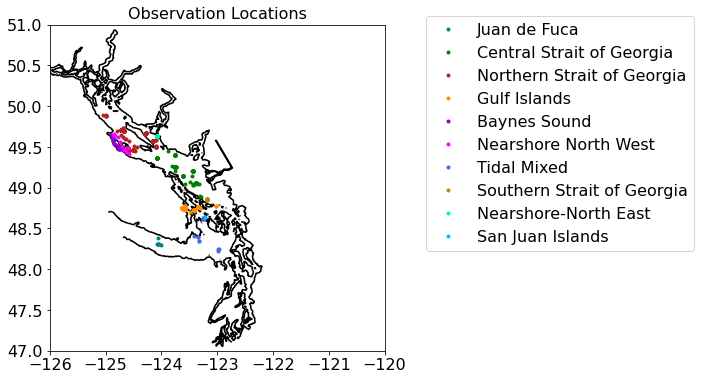

In [232]:
fig, ax = plt.subplots(1,1,figsize = (6,6))
with nc.Dataset('/ocean/ksuchy/MOAD/NEMO-forcing/grid/bathymetry_201702.nc') as grid:
    viz_tools.plot_coastline(ax, grid, coords = 'map',isobath=.1)
colors=('teal','green','firebrick','darkorange','darkviolet','fuchsia',
        'royalblue','darkgoldenrod','mediumspringgreen','deepskyblue')
datreg=dict()
for ind, iregion in enumerate(data.region_name.unique()):
    datreg[iregion] = data.loc[data.region_name==iregion]
    ax.plot(datreg[iregion]['Lon'], datreg[iregion]['Lat'],'.',
            color = colors[ind], label=iregion)
ax.set_ylim(47,51)
ax.legend(bbox_to_anchor=[1,.6,0,0])
ax.set_xlim(-126, -120);
ax.set_title('Observation Locations');
ax.legend(bbox_to_anchor=(1.1, 1.05))




In [233]:
#look at data for individual years
View2012=data.loc[data.Year==2012]
View2013=data.loc[data.Year==2013]
View2014=data.loc[data.Year==2014]
View2015=data.loc[data.Year==2015]



In [234]:
# define log transform function with slight shift to accommodate zero values
def logt(x):
  return np.log10(x+.001)

In [235]:
#look at data for a specific region
ViewCentralSoG=data.loc[data.region_name=='Central Strait of Georgia']

In [236]:
#look at data for an individual station
ViewGEO1=data.loc[data.Station=='GEO1']

### Calculate Mean and SEMs

In [237]:
#monthly mean and SEM for entire SoG
monthlymean=data.groupby(['Month']).mean()

In [238]:
monthlysem=data.groupby(['Month']).sem()

In [239]:
#monthly mean and SEM for Central SoG Only
monthlymeanCentral=ViewCentralSoG.groupby(['Month']).mean()

In [240]:
monthlysemCentral=ViewCentralSoG.groupby(['Month']).sem()

In [241]:
#monthly mean and SEM for station GEO1 only
monthlymeanGEO1=ViewGEO1.groupby(['Month']).mean()

In [242]:
monthlysemGEO1=ViewGEO1.groupby(['Month']).sem()

In [243]:
#look at data for an individual station
ViewBaynes=data.loc[data.Station=='BS-1']

In [244]:
#monthly mean and SEM for Baynes Sound Only
monthlymeanBaynes=ViewBaynes.groupby(['Month']).mean()

In [245]:
monthlymean2012=View2012.groupby(['Month']).mean()
monthlymean2013=View2013.groupby(['Month']).mean()
monthlymean2014=View2014.groupby(['Month']).mean()
monthlymean2015=View2015.groupby(['Month']).mean()

In [246]:
monthlysem2012=View2012.groupby(['Month']).sem()
monthlysem2013=View2013.groupby(['Month']).sem()
monthlysem2014=View2014.groupby(['Month']).sem()
monthlysem2015=View2015.groupby(['Month']).sem()

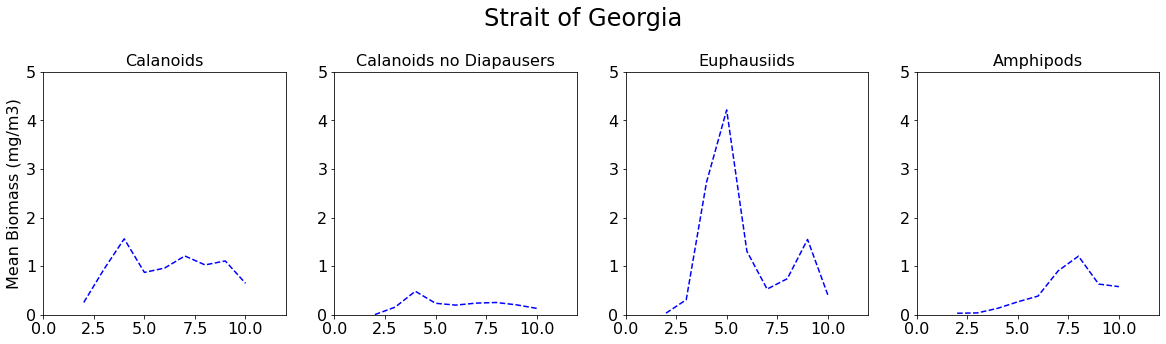

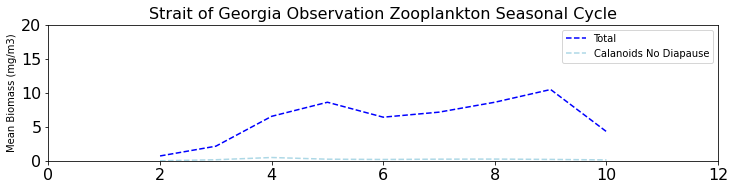

In [275]:
fig,ax=plt.subplots(1,4,figsize=(20,5))
fig.suptitle('Strait of Georgia', fontsize=24)
fig.subplots_adjust(top=0.8)
#ax[0].errorbar(monthlymean.index,logt_inv(monthlymean['L10Calanoids']),
#                  yerr=logt_inv(np.array([monthlymean['L10Calanoids']-monthlysem['L10Calanoids'],
#                 monthlymean['L10Calanoids']+monthlysem['L10Calanoids']])),
#               fmt='ro',capsize=5)
ax[0].plot(logt_inv(monthlymean['L10Calanoids']),'b--')
#ax[1].errorbar(monthlymean.index,logt_inv(monthlymean['L10CalanoidsDiaRemoved']),
#               yerr=logt_inv(np.array([monthlymean['L10CalanoidsDiaRemoved']-monthlysem['L10CalanoidsDiaRemoved'],
#                 monthlymean['L10CalanoidsDiaRemoved']+monthlysem['L10CalanoidsDiaRemoved']])),
#               fmt='ro',capsize=5)
ax[1].plot(logt_inv(monthlymean['L10CalanoidsDiaRemoved']),'b--')
#ax[2].errorbar(monthlymean.index,logt_inv(monthlymean['L10Euphausiids']),
#               yerr=logt_inv(np.array([monthlymean['L10Euphausiids']-monthlysem['L10Euphausiids'],
#                 monthlymean['L10Euphausiids']+monthlysem['L10Euphausiids']])),
#               fmt='ro',capsize=5)
ax[2].plot(logt_inv(monthlymean['L10Euphausiids']),'b--')
#ax[3].errorbar(monthlymeanCentral.index,logt_inv(monthlymeanCentral['L10Hyperiids']),
#               yerr=logt_inv(np.array([monthlymeanCentral['L10Hyperiids']-monthlysemCentral['L10Hyperiids'],
#                 monthlymeanCentral['L10Hyperiids']+monthlysemCentral['L10Hyperiids']])),
#               fmt='ro',capsize=5)
ax[3].plot(logt_inv(monthlymean['L10Hyperiids']),'b--')
ax[0].set_title('Calanoids')
ax[1].set_title('Calanoids no Diapausers')
ax[2].set_title('Euphausiids')
ax[3].set_title('Amphipods')
ax[0].set_ylabel('Mean Biomass (mg/m3)')
ax[0].set_xlim(0,12)
ax[1].set_xlim(0,12)
ax[2].set_xlim(0,12)
ax[3].set_xlim(0,12)
ax[0].set_ylim(0,5)
ax[1].set_ylim(0,5)
ax[2].set_ylim(0,5)
ax[3].set_ylim(0,5)

fig,ax=plt.subplots(1,1,figsize=(12,2.5))
ax.plot(logt_inv(monthlymean['L10Total']),'--',color='blue',label='Total')
ax.plot(logt_inv(monthlymean['L10CalanoidsDiaRemoved']),'--',color='lightblue',label='Calanoids No Diapause')
ax.set_ylim(0,20)
ax.set_xlim(0,12)
ax.set_title('Strait of Georgia Observation Zooplankton Seasonal Cycle')
ax.set_ylabel('Mean Biomass (mg/m3)',fontsize=10)
ax.legend(fontsize=10)

(0.0, 5.0)

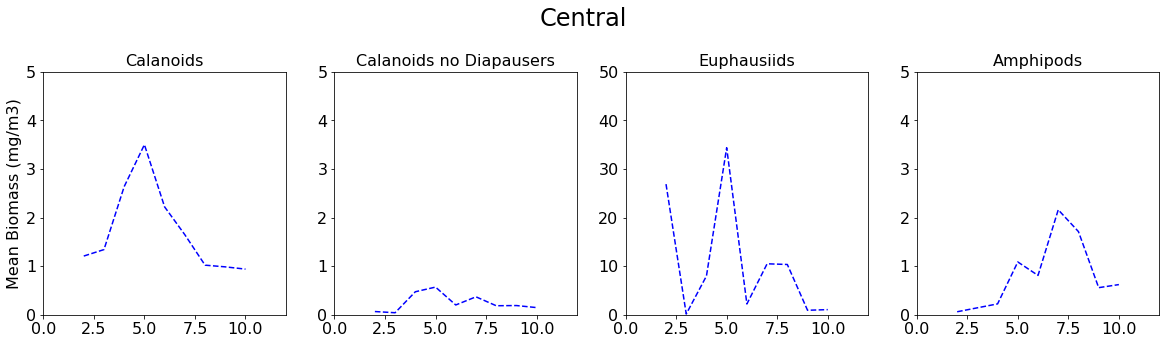

In [277]:
fig,ax=plt.subplots(1,4,figsize=(20,5))
fig.suptitle('Central', fontsize=24)
fig.subplots_adjust(top=0.8)
ax[0].plot(logt_inv(monthlymeanCentral['L10Calanoids']),'b--')
ax[1].plot(logt_inv(monthlymeanCentral['L10CalanoidsDiaRemoved']),'b--')
ax[2].plot(logt_inv(monthlymeanCentral['L10Euphausiids']),'b--')
ax[3].plot(logt_inv(monthlymeanCentral['L10Hyperiids']),'b--')
ax[0].set_title('Calanoids')
ax[1].set_title('Calanoids no Diapausers')
ax[2].set_title('Euphausiids')
ax[3].set_title('Amphipods')
ax[0].set_ylabel('Mean Biomass (mg/m3)')
ax[0].set_xlim(0,12)
ax[1].set_xlim(0,12)
ax[2].set_xlim(0,12)
ax[3].set_xlim(0,12)
ax[0].set_ylim(0,5)
ax[1].set_ylim(0,5)
ax[2].set_ylim(0,50)
ax[3].set_ylim(0,5)

(0.0, 20.0)

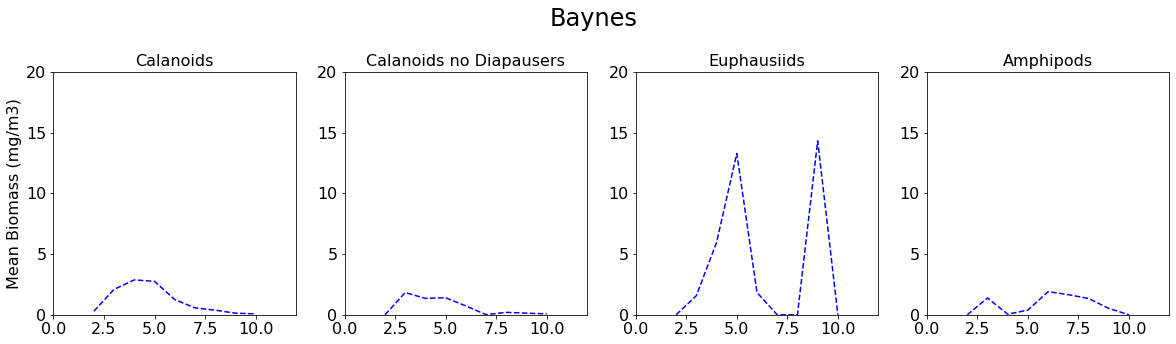

In [268]:
fig,ax=plt.subplots(1,4,figsize=(20,5))
fig.suptitle('Baynes', fontsize=24)
fig.subplots_adjust(top=0.8)
ax[0].plot(logt_inv(monthlymeanBaynes['L10Calanoids']),'b--')
ax[1].plot(logt_inv(monthlymeanBaynes['L10CalanoidsDiaRemoved']),'b--')
ax[2].plot(logt_inv(monthlymeanBaynes['L10Euphausiids']),'b--')
ax[3].plot(logt_inv(monthlymeanBaynes['L10Hyperiids']),'b--')
ax[0].set_title('Calanoids')
ax[1].set_title('Calanoids no Diapausers')
ax[2].set_title('Euphausiids')
ax[3].set_title('Amphipods')
ax[0].set_ylabel('Mean Biomass (mg/m3)')
ax[0].set_xlim(0,12)
ax[1].set_xlim(0,12)
ax[2].set_xlim(0,12)
ax[3].set_xlim(0,12)
ax[0].set_ylim(0,20)
ax[1].set_ylim(0,20)
ax[2].set_ylim(0,20)
ax[3].set_ylim(0,20)

Text(0, 0.5, 'Mean Biomass (mg/m3)')

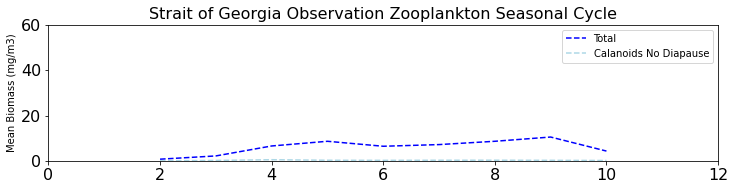

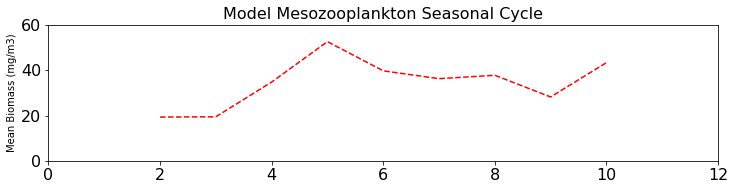

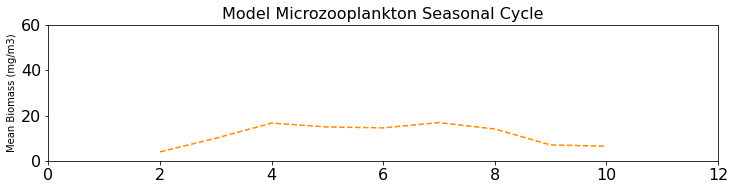

In [272]:
fig,ax=plt.subplots(1,1,figsize=(12,2.5))
ax.plot(logt_inv(monthlymean['L10Total']),'--',color='blue',label='Total')
ax.plot(logt_inv(monthlymean['L10CalanoidsDiaRemoved']),'--',color='lightblue',label='Calanoids No Diapause')
ax.set_ylim(0,60)
ax.set_xlim(0,12)
ax.set_title('Strait of Georgia Observation Zooplankton Seasonal Cycle')
ax.set_ylabel('Mean Biomass (mg/m3)',fontsize=10)
ax.legend(fontsize=10)

fig,ax=plt.subplots(1,1,figsize=(12,2.5))
ax.plot(logt_inv(monthlymean['L10mod_mesozooplankton']),'--',color='red',label='Model Microzoop')
ax.set_ylim(0,60)
ax.set_xlim(0,12)
ax.set_title('Model Mesozooplankton Seasonal Cycle')
ax.set_ylabel('Mean Biomass (mg/m3)',fontsize=10)

fig,ax=plt.subplots(1,1,figsize=(12,2.5))
ax.plot(logt_inv(monthlymean['L10mod_microzooplankton']),'--',color='darkorange',label='Model Microzoop')
ax.set_ylim(0,60)
ax.set_xlim(0,12)
ax.set_title('Model Microzooplankton Seasonal Cycle')
ax.set_ylabel('Mean Biomass (mg/m3)',fontsize=10)

In [251]:
data.keys()

Index(['Key', 'region_name', 'Station', 'Lon', 'Lat', 'Date', 'dtUTC',
       'Twilight', 'Net_Type', 'Mesh_Size(um)',
       ...
       'k_lower', 'L10Calanoids', 'L10CalanoidsDiaRemoved', 'L10Euphausiids',
       'L10Hyperiids', 'L10Gammariids', 'L10Neocalanus', 'L10Total',
       'L10mod_mesozooplankton', 'L10mod_microzooplankton'],
      dtype='object', length=287)

In [252]:
data['Calanoids']

0      1.157396
1      0.310793
2      0.292791
3      1.391521
4      0.855453
         ...   
461    0.346093
462    0.390772
463    0.075827
464    0.077561
465    0.894605
Name: Calanoids, Length: 466, dtype: float64

KeyError: 'Calanoida'

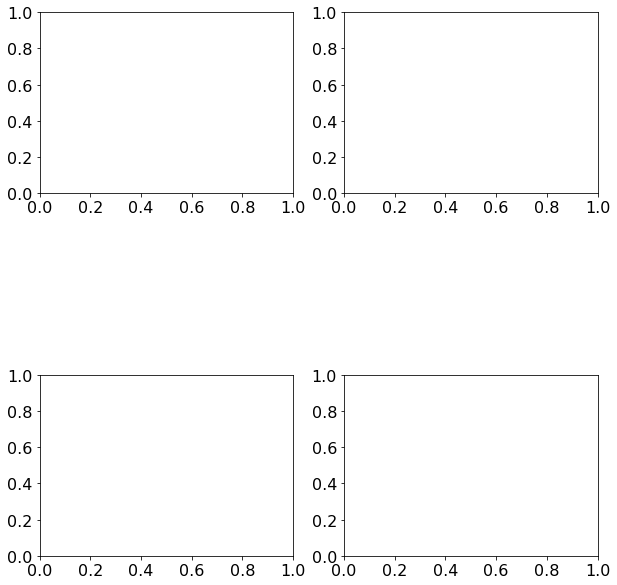

In [253]:
fig,ax=plt.subplots(2,2,figsize=(10,10))
fig.subplots_adjust(hspace=1)
ax=ax.flatten()
ax[0].plot(data['Calanoida']+data['Euphausiacea']+data['Amphipoda'],data['mod_mesozooplankton'],'k.')
ax[0].set_title('Copepods Euphausiids Amphipods ($\mu$M)')
ax[0].set_xlabel('Obs')
ax[0].set_ylabel('Model')
ax[0].plot((0,10),(0,10),'r-',alpha=.3)

ax[1].plot(logt(data['Calanoida']+data['Euphausiacea']+data['Amphipoda']),logt(data['mod_mesozooplankton']),'k.')
ax[1].set_title('Log10 Copepods Euphausiids Amphipods ($\mu$M)')
ax[1].set_xlabel('Obs')
ax[1].set_ylabel('Model')
ax[1].plot((-3,3),(-3,3),'r-',alpha=.3)

ax[2].plot(data['Calanoida']+data['Euphausiacea']+data['Amphipoda']+data['Decapoda']+data['Copelata'],data['mod_mesozooplankton'],'k.')
ax[2].set_title('Total ($\mu$M)')
ax[2].set_xlabel('Obs')
ax[2].set_ylabel('Model')
ax[2].plot((0,10),(0,10),'r-',alpha=.3)

ax[3].plot(logt(data['Calanoida']+data['Euphausiacea']+data['Amphipoda']+data['Decapoda']+data['Copelata']),logt(data['mod_mesozooplankton']),'k.')
ax[3].set_title('Log10 Total ($\mu$M)')
ax[3].set_xlabel('Obs')
ax[3].set_ylabel('Model')
ax[3].plot((-3,3),(-3,3),'r-',alpha=.3)

In [ ]:
#fig,ax=plt.subplots(1,1,figsize=(10,10))
#ax.plot((data['L10Calanoida']),(data['L10mod_mesozooplankton']),'k.')
#ax.set_title('Log10 Total ($\mu$M)')
#ax.set_xlabel('Obs')
#ax.set_ylabel('Model')
#ax.plot((-3,3),(-3,3),'r-',alpha=.3)

In [ ]:
def yd(idt):
    if type(idt)==dt.datetime:
        yd=(idt-dt.datetime(idt.year-1,12,31)).days
    else: # assume array or pandas
        yd=[(ii-dt.datetime(ii.year-1,12,31)).days for ii in idt]
    return yd

data['yd']=yd(data['dtUTC'])
data['Year']=[ii.year for ii in data['dtUTC']]

#### By Day of Year

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(7,7))
m=ax.scatter(logt(data['Calanoida']+data['Euphausiacea']+data['Amphipoda']),logt(data['mod_mesozooplankton']),
          c=data['yd'],s=5,cmap=cmocean.cm.phase)

ax.set_title('log10[ Copepods Amphipods Euphausiids + 0.001] By Year Day')
ax.set_xlabel('Obs')
ax.set_ylabel('Model')
ax.plot((-6,5),(-6,5),'r-',alpha=.3)
ax.set_xlim(-1.5,1.5)
ax.set_ylim(-1.5,1.5);
fig.colorbar(m)

In [ ]:
data['Month']=[ii.month for ii in data['dtUTC']]
JF=data.loc[(data.Month==1)|(data.Month==2)]
MAM=data.loc[(data.Month==3)|(data.Month==4)|(data.Month==5)]
JJA=data.loc[(data.Month==6)|(data.Month==7)|(data.Month==8)]
SOND=data.loc[(data.Month==9)|(data.Month==10)|(data.Month==11)|(data.Month==12)]

In [ ]:


def byRegion(ax,obsvar,modvar,lims):
    SoG=[]
    for ind, iregion in enumerate(data.region_name.unique()):
        #ax.plot(datreg[iregion]['Lon'], datreg[iregion]['Lat'],'.',
                #color = colors[ind], label=iregion)
        SoG0=et.varvarPlot(ax,datreg[iregion],obsvar,modvar,
                          cols=(colors[ind],),lname=iregion)
        SoG.append(SoG0)
    l=ax.legend(handles=[ip[0][0] for ip in SoG])
    ax.set_xlabel('Obs')
    ax.set_ylabel('Model')
    ax.plot(lims,lims,'k-',alpha=.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect(1)
    return SoG,l



In [ ]:
def bySeason(ax,obsvar,modvar,lims):
    for axi in ax:
        axi.plot(lims,lims,'k-')
        axi.set_xlim(lims)
        axi.set_ylim(lims)
        axi.set_aspect(1)
        axi.set_xlabel('Obs')
        axi.set_ylabel('Model')
    SoG=et.varvarPlot(ax[0],JF,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[0].set_title('Winter')
    SoG=et.varvarPlot(ax[1],MAM,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[1].set_title('Spring')
    SoG=et.varvarPlot(ax[2],JJA,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[2].set_title('Summer')
    SoG=et.varvarPlot(ax[3],SOND,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[3].set_title('Autumn')
    return 

In [ ]:
#obsvar='L10Calanoida'
#modvar='L10mod_mesozooplankton'

### Plots of Calanoid copepods vs. model mesozooplankton 2015

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (16,7))

             
SoG,l=byRegion(ax,'L10Calanoida','L10mod_mesozooplankton',(-1.5,1.5))
ax.set_title('Log 10 Calanoida + 0.001 ($\mu$M) By Region')
ax.legend(bbox_to_anchor=(1.1, 1.05))

fig, ax = plt.subplots(1,4,figsize = (16,3.3))
bySeason(ax,'L10Calanoida','L10mod_mesozooplankton',(-1.5,1.5))


#### 

In [ ]:
#obsvar='Euphausiacea'
#modvar='mod_mesozooplankton'

### Plots of Euphausiids vs. model mesozooplankton 2015

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (16,7))
SoG,l=byRegion(ax,'L10Euphausiacea','L10mod_mesozooplankton',(-1.5,1.5))
ax.set_title('Log 10 Euphausiacea + 0.001 ($\mu$M) By Region');
ax.legend(bbox_to_anchor=(1.1, 1.05))

fig, ax = plt.subplots(1,4,figsize = (16,3.3))
bySeason(ax,'L10Euphausiacea','L10mod_mesozooplankton',(-1.5,1.5))

### Plots of Amphipods vs. model mesozooplankton 2015

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (16,7))
SoG,l=byRegion(ax,'L10Amphipoda','L10mod_mesozooplankton',(-1.5,1.5))
ax.set_title('Log 10 Amphipoda + 0.001 ($\mu$M) By Region');
ax.legend(bbox_to_anchor=(1.1, 1.05))

fig, ax = plt.subplots(1,4,figsize = (16,3.3))
bySeason(ax,'L10Amphipoda','L10mod_mesozooplankton',(-1.5,1.5))

### Decapods vs. model mesozooplankton 2015

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (16,7))
SoG,l=byRegion(ax,'L10Decapoda','L10mod_mesozooplankton',(-1.5,1.5))
ax.set_title('Log 10 Decapoda + 0.001 ($\mu$M) By Region');
ax.legend(bbox_to_anchor=(1.1, 1.05))

fig, ax = plt.subplots(1,4,figsize = (16,3.3))
bySeason(ax,'L10Decapoda','L10mod_mesozooplankton',(-1.5,1.5))

### Larvaceans vs. model mesozooplankton 2015

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (16,7))
SoG,l=byRegion(ax,'L10Copelata','L10mod_mesozooplankton',(-1.5,1.5))
ax.set_title('Log 10 Larvaceans + 0.001 ($\mu$M) By Region');
ax.legend(bbox_to_anchor=(1.1, 1.05))

fig, ax = plt.subplots(1,4,figsize = (16,3.3))
bySeason(ax,'L10Copelata','L10mod_mesozooplankton',(-1.5,1.5))

### Plots of Cyclopoid copepods vs. model mesozooplankton 2015

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (16,7))

SoG,l=byRegion(ax,'L10Cyclopoida','L10mod_mesozooplankton',(-1.5,1.5))
ax.set_title('Log 10 Cyclopoida + 0.001 ($\mu$M) By Region');
ax.legend(bbox_to_anchor=(1.1, 1.05))

fig, ax = plt.subplots(1,4,figsize = (16,3.3))
bySeason(ax,'L10Cyclopoida','L10mod_mesozooplankton',(-1.5,1.5))

### Calanoid copepods vs. model microzooplankton from Mar-Jun 2015

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (16,7))

SoG,l=byRegion(ax,'L10Calanoida','L10mod_microzooplankton',(-1.5,1.5))
ax.set_title('Log10 Calanoida +0.001 ($\mu$M) By Region');
ax.legend(bbox_to_anchor=(1.1, 1.05))

fig, ax = plt.subplots(1,4,figsize = (16,3.3))
bySeason(ax,'L10Cyclopoida','L10mod_mesozooplankton',(-1.5,1.5))

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (16,7))

SoG,l=byRegion(ax,'L10Copelata','L10mod_microzooplankton',(-1.5,1.5))
ax.set_title('Log10 Larvaceans +0.001 ($\mu$M) By Region');
ax.legend(bbox_to_anchor=(1.1, 1.05))

fig, ax = plt.subplots(1,4,figsize = (16,3.3))
bySeason(ax,'L10Copelata','L10mod_microzooplankton',(-1.5,1.5))
